# Лабораторная работа №5
# Система массового обслуживания

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
def timed_data(time_and_data, time_period=(0, 100), mark=None):
    times = []
    data = []
    for time, snap in time_and_data:
        times.append(time)
        data.append(snap)
    if mark is None:
        plt.plot(times, data)
    else:
        plt.plot(times, data, 'o')
    plt.xlim(time_period)
    plt.show()

In [3]:
class ServiceDecision(Enum):
    ACCEPT = 0
    REJECT = 1

class Request:
    class Status(Enum):
        AWAITING = 0
        COMPLETED = 1
        REJECTED = 2

    def __init__(self, status, appearance_time):
        self.status = status
        self.appearance_time = appearance_time

class Service:
    def __init__(self, n=None, m=None, lambd=None, mu=None, p=None):
        self.amount_of_services = np.infty if n is None else n
        self.queue_max_size = np.infty if m is None else m
        self.requests_freq = 1 if lambd is None else lambd
        self.service_freq = 1 if mu is None else mu
        self.acception_prob = 1 if p is None else p
        self.rejection_prob = 1 - self.acception_prob
        self.init_empty_state()
        self.init_stats_items()
        self.new_awaiting_request()

        
    def init_empty_state(self):
        self.all_requests = []
        self.queue = []
        self.current_time = 0.0
        self.services_in_work = 0
        

    def init_stats_items(self):
        self.queue_sizes_during_time = []
        self.amount_of_working_services_during_time = []
        self.completed_requests_amount = 0
        self.rejected_requests_amount = 0
        self.all_requests_amount = 0

        
    def request_time_delta(self):
        return np.random.exponential(1 / self.requests_freq)

    
    def service_time_delta(self):
        return np.random.exponential(1 / self.service_freq)

    
    def new_awaiting_request(self):
        self.all_requests_amount += 1
        request = Request(
            status=Request.Status.AWAITING, 
            appearance_time=self.current_time+self.request_time_delta()
        )
        self.add_request(request)

        
    def add_request(self, request):
        self.all_requests.append(request)
        self.all_requests = sorted(self.all_requests, key=lambda req: req.appearance_time)

        
    def start_work(self):
        self.services_in_work += 1
        decision = np.random.choice(
            [ServiceDecision.ACCEPT, ServiceDecision.REJECT],
            p=[self.acception_prob, self.rejection_prob]
        )
        if decision is ServiceDecision.ACCEPT:
            req = Request(
                status=Request.Status.COMPLETED, 
                appearance_time=self.current_time+self.service_time_delta()
            )
            self.add_request(req)
        elif decision is ServiceDecision.REJECT:
            req = Request(
                status=Request.Status.REJECTED, 
                appearance_time=self.current_time+self.service_time_delta()
            )
            self.add_request(req)

            
    def process_awaiting_request(self, req):
        self.current_time = req.appearance_time
        if self.services_in_work < self.amount_of_services:
            self.start_work()
        elif len(self.queue) < self.queue_max_size:
            self.queue.append(req) 
        else:
            self.rejected_requests_amount += 1


    def process_completed_request(self, req):
        self.current_time = req.appearance_time
        self.services_in_work -= 1
        if len(self.queue) != 0:
            self.queue.pop(0)
            self.start_work()


    def process_rejected_request(self, req):
        self.current_time = req.appearance_time
        self.services_in_work -= 1
        req.status = Request.Status.AWAITING
        self.process_awaiting_request(req)


    def start_accepting_requests(self, time_end=None):
        assert time_end is not None, "END TIME IS NOT SET"
        while self.current_time < time_end:
            request = self.all_requests.pop(0)
            if self.current_time >= time_end:
                break
            self.queue_sizes_during_time.append((self.current_time, len(self.queue)))
            self.amount_of_working_services_during_time.append((self.current_time, self.services_in_work))
            if request.status is Request.Status.AWAITING:
                self.process_awaiting_request(request)
                self.new_awaiting_request()
            elif request.status is Request.Status.COMPLETED:
                self.process_completed_request(request)
                self.completed_requests_amount += 1
                self.all_requests_amount += 1
            elif request.status is Request.Status.REJECTED:
                self.process_rejected_request(request)
                self.rejected_requests_amount += 1
                self.all_requests_amount += 1

                
    def get_service_stats(self):
        return {
            "queue_sizes_during_time": self.queue_sizes_during_time,
            "amount_of_working_services_during_time": self.amount_of_working_services_during_time
        }
            

In [4]:
def final_probs_of_states_practical(stats, total_working_time=None):
    assert total_working_time is not None, "TOTAL WORKING TIME IS NOT SET"
    
    time_and_queue_sizes = stats["queue_sizes_during_time"]
    time_and_amount_of_working_services = stats["amount_of_working_services_during_time"]
    
    time_points = [j for j, i in time_and_queue_sizes]
    queue_sizes = [i for j, i in time_and_queue_sizes]
    working_services_amount = [i for j, i in time_and_amount_of_working_services]
    
    probs = [0 for _ in range(max(queue_sizes) + max(working_services_amount) + 1)]
    time_step = 0
    for queue_size, services_working, time in zip(queue_sizes, working_services_amount, time_points):
        probs[queue_size + services_working] += time - time_step
        time_step = time
    return [p / total_working_time for p in probs] 

def final_probs_of_states_theoretical(s):
    time_and_queue_sizes = stats["queue_sizes_during_time"]
    time_and_amount_of_working_services = stats["amount_of_working_services_during_time"]
    queue_sizes = [i for j, i in time_and_queue_sizes]
    working_services_amount = [i for j, i in time_and_amount_of_working_services]
    
    load_intensity = s.requests_freq / s.service_freq
    n = max(working_services_amount)
    m = max(queue_sizes)
    probs = [1]
    for i in range(1, n + 1):
        probs.append((load_intensity ** i) / np.math.factorial(i))
    for i in range(1, m + 1):
        probs.append((load_intensity ** (n+i)) / (n**i * np.math.factorial(n)))
    p0 = sum(probs)
    return [p * (1/p0) for p in probs]

In [5]:
s = Service(n=3, m=4, lambd=10, mu=6, p=0.99)
time_end = 10000
s.start_accepting_requests(time_end=time_end)
stats = s.get_service_stats()

## Финальные вероятности состояний

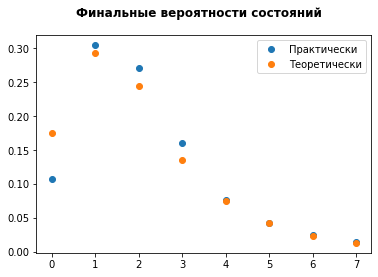

In [6]:
probs0 = final_probs_of_states_practical(stats, time_end)
plt.plot(probs0, 'o', label="Практически")
probs1 = final_probs_of_states_theoretical(s)
plt.plot(probs1, 'o', label="Теоретически")
plt.suptitle("Финальные вероятности состояний", fontweight='bold')
plt.legend()
plt.show()

## Вероятность отклонения заявки

In [7]:
def reject_prob_practical(s):
    return s.rejected_requests_amount / (s.all_requests_amount)

def reject_prob_theoretical(s):
    return final_probs_of_states_theoretical(s)[-1]

print(f"Практическая: {reject_prob_practical(s)}", f"Теоретическая: {reject_prob_theoretical(s)}")

Практическая: 0.012213946378527433 Теоретическая: 0.012895740353325955


## Абсолютная пропускная способность

In [8]:
print(f"Практическая: {s.requests_freq * (1 - reject_prob_practical(s))}", f"Теоретическая: {s.requests_freq * (1 - reject_prob_theoretical(s))}")

Практическая: 9.877860536214726 Теоретическая: 9.87104259646674


## Среднее число заявок

In [9]:
print(
    f"Практически: {sum(i * j for i, j in enumerate(final_probs_of_states_practical(stats, time_end)))}",
    f"Теоретически: {sum(i * j for i, j in enumerate(final_probs_of_states_theoretical(s)))}",
)

Практически: 2.0896557048506854 Теоретически: 1.9251660806292032


## Среднее количество работающих каналов

In [10]:
time_and_queue_sizes = stats["queue_sizes_during_time"]
queue_sizes = [i for j, i in time_and_queue_sizes]
m = max(queue_sizes)
print(
    f"Практически: {sum(i * j for i, j in enumerate(final_probs_of_states_practical(stats, time_end)[:m-1]))}",
    f"Теоретически: {sum(i * j for i, j in enumerate(final_probs_of_states_theoretical(s)[:m-1]))}",
)

Практически: 0.8471087547549372 Теоретически: 0.7797561058545093


## График работающих каналов

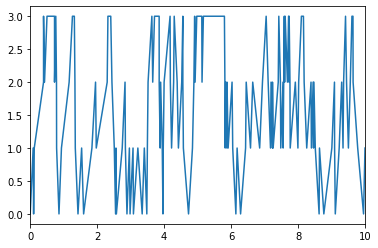

In [11]:
time_and_amount_of_working_services = stats["amount_of_working_services_during_time"]
timed_data(time_and_amount_of_working_services, (0, 10))

## Среднее число элементов в очереди

In [12]:
time_and_queue_sizes = stats["queue_sizes_during_time"]
working_services_amount = [i for j, i in time_and_amount_of_working_services]
m = max(working_services_amount)
print(
    f"Практически: {sum((i - m if i > m else 0) * j for i, j in enumerate(final_probs_of_states_practical(stats, time_end)))}",
    f"Теоретически: {sum((i - m if i > m else 0) * j for i, j in enumerate(final_probs_of_states_theoretical(s)))}",
)

Практически: 0.28984604052583174 Теоретически: 0.27999231455141316


## График количества элементов в очереди

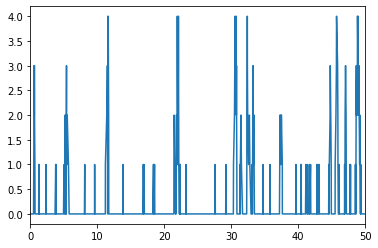

In [13]:
time_and_queue_sizes = stats["queue_sizes_during_time"]
timed_data(time_and_queue_sizes, (0, 50))

## Состояние СМО в единицу времени

In [14]:

def kek(stats):
    time_and_queue_sizes = stats["queue_sizes_during_time"]
    time_and_amount_of_working_services = stats["amount_of_working_services_during_time"]
    
    time_points = [j for j, i in time_and_queue_sizes]
    queue_sizes = [i for j, i in time_and_queue_sizes]
    working_services_amount = [i for j, i in time_and_amount_of_working_services]

    time_with_state = []
    
    system_state = [i for i in range(max(queue_sizes) + max(working_services_amount) + 1)]
    for queue_size, services_working, time in zip(queue_sizes, working_services_amount, time_points):
        time_with_state.append((time, system_state[queue_size + services_working])) 
    return time_with_state

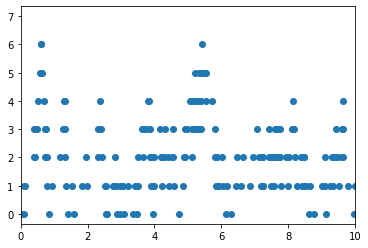

In [15]:
timed_data(kek(stats), (0, 10), 'o')

## Установление стационарного режима СМО

In [16]:
time_and_queue_sizes = stats["queue_sizes_during_time"]
time_and_amount_of_working_services = stats["amount_of_working_services_during_time"]
    
time_points = [j for j, i in time_and_queue_sizes]
queue_sizes = [i for j, i in time_and_queue_sizes]
working_services_amount = [i for j, i in time_and_amount_of_working_services]
   
r = []
probs = [0 for _ in range(max(queue_sizes) + max(working_services_amount) + 1)]
time_step = 0
for queue_size, services_working, time in zip(queue_sizes, working_services_amount, time_points):
    probs[queue_size + services_working] += time - time_step
    if queue_size + services_working == 0:
        r.append(probs[queue_size + services_working] / time_end)
    time_step = time
r[len(r)-30:]

[0.10649900230644994,
 0.10650329075616241,
 0.10652323603208565,
 0.10652527760817407,
 0.10652722364040142,
 0.10654188166365762,
 0.10655381751146646,
 0.10656059619589864,
 0.10657206410276426,
 0.10657241184071822,
 0.10658426325159394,
 0.10659619062998568,
 0.10659883855610856,
 0.1066008822422354,
 0.106616408622878,
 0.10662102949489431,
 0.10662397100843604,
 0.10663067692723993,
 0.10663167294836162,
 0.10663333364585682,
 0.10664419777941361,
 0.10664908090186086,
 0.10665423650539083,
 0.1066675498306056,
 0.106674680781525,
 0.10667486739564351,
 0.10668760687220834,
 0.10669077231177193,
 0.10669104156367698,
 0.10669199187592708]